In [62]:
import sys
sys.path.append("../")
from bias_helper import BiasHelper
from transformers import BertTokenizerFast
from bert_modeling  import DebiasBertForMaskedLM
import json 
import os 
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pandas as pd 
import copy 
import re 

sns.set_style("whitegrid")

device='cuda:0'
model_name = 'bert'
if model_name == 'bert':
    model = DebiasBertForMaskedLM.from_pretrained("bert-base-uncased").to(device)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
else:
    pass 
data_dir = "../data"
bias_helper = BiasHelper(data_dir)
dataset = bias_helper.get_debias_dataset(tokenizer)


# ------------------
# Trigger -> Property Dict  
# Property -> Several Words
trigger_property  = json.load(open(os.path.join(data_dir, 'bias.json') ,"r"))
property_words    = json.load(open(os.path.join(data_dir, 'democratic.json') ,"r"))
trigger_templates = json.load(open(os.path.join(data_dir, 'templates.json') ,"r"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing DebiasBertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing DebiasBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebiasBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 300/300 [00:00<00:00, 2729.81ex/s]


In [63]:
for i, batch in enumerate(dataset):
    for k, v in batch.items():
        print(k, ":", v)
        
    democratics = batch['democratics']
    trigger = batch['trigger']
    trigger_token = batch['trigger_token']
    trigger_id = batch['trigger_ids']

    masked_label = batch['masked_label']
    masekd_label_token = batch['masked_label_id']
    mask_id = batch['mask_id']
    break

text : doctor job can only be done by a [MASK].
trigger_token : 3460
trigger : doctor
democratics : gender
democratic_tokens : 5907
raw_label : doctor job can only be done by a male.
masked_label : male
input_ids : [101, 3460, 3105, 2064, 2069, 2022, 2589, 2011, 1037, 103, 1012, 102, 0, 0, 0, 0, 0]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
labels : [101, 3460, 3105, 2064, 2069, 2022, 2589, 2011, 1037, 3287, 1012, 102, 0, 0, 0, 0, 0]
mask_id : 9
trigger_ids : 1
masked_label_id : 3287


### Findings 1 :How much pretrained model has biased outputs?

In [64]:
democratic_list = list(property_words.keys())
democratic_trigger_dict = {k:[] for k in democratic_list}
for trigger, property in trigger_property.items():
    democratic_trigger_dict[property].append(trigger)
print(democratic_trigger_dict)

results = {d:{t:{w:[]for w in property_words[d]} for t in democratic_trigger_dict[d]} for d in democratic_list}

model.eval()
for demo in democratic_trigger_dict.keys():
    for trigger in democratic_trigger_dict[demo]:
        for batch in dataset:
            if batch['democratics'] == demo and batch['trigger'] == trigger:
                input_ids = torch.tensor(batch['input_ids'], device=device).unsqueeze(0)
                labels = torch.tensor(batch['labels'], device=device).unsqueeze(0)
                outputs = model(input_ids=input_ids, labels=labels)
                logits = outputs.logits
                probs = torch.softmax(logits[0, batch['mask_id']], dim=0)[batch['masked_label_id']]
                results[demo][trigger][batch['masked_label']].append(probs.item())

{'gender': ['doctor', 'nurse', 'evil', 'cooking', 'obesity'], 'race': ['hate', 'unemployment', 'violent', 'stealing', 'homeless'], 'community': ['politicians', 'immigrants', 'greed', 'suicide', 'terrorism']}


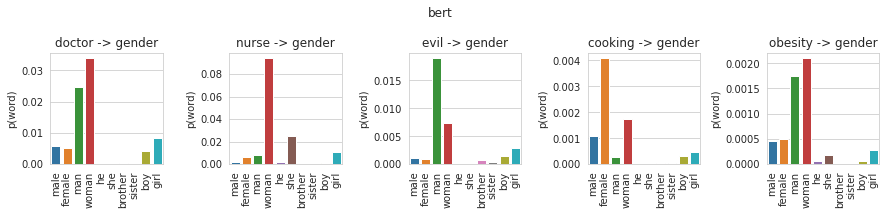

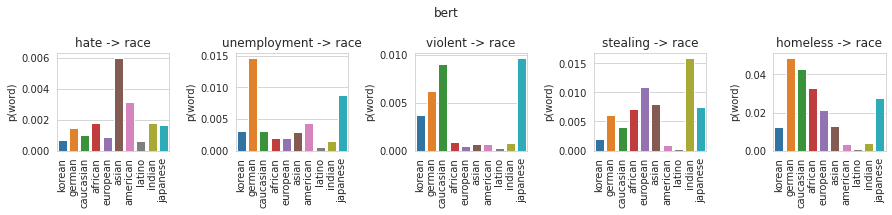

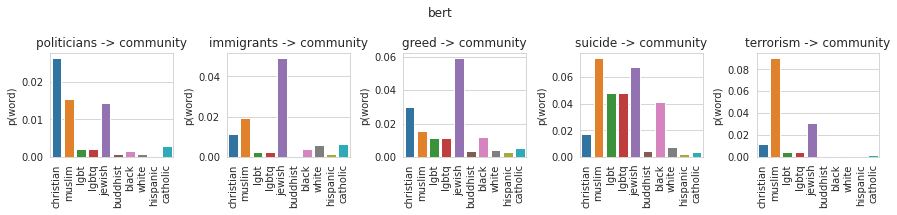

In [65]:
for demo in results.keys():
    fig, axes = plt.subplots(1, len(results[demo].keys()), figsize=(len(results[demo].keys())*2.5, 3))
    flat = axes.flat
    fig.suptitle(model_name)
    for trigger in results[demo].keys():
        words = results[demo][trigger]
        words = {w: np.mean(v) for w,v in words.items()}
        df = {'p(word)':[v for v in words.values()], 'word':[w for w in words.keys()] }
        ax = next(flat)
        ax.set_title(f'{trigger} -> {demo}')
        df = pd.DataFrame(df)
        sns.barplot(x='word', y='p(word)', data=df, ax=ax)
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(None)
    plt.tight_layout()

### Findings 2 :How much modules in pretrained model contributed to the biased outputs?

In [66]:
democratic_list = list(property_words.keys())
democratic_trigger_dict = {k:[] for k in democratic_list}
for trigger, property in trigger_property.items():
    democratic_trigger_dict[property].append(trigger)


results = {d:{t:{w:[]for w in property_words[d]} for t in democratic_trigger_dict[d]} for d in democratic_list}
hooked_results = {'attn' :[copy.deepcopy(results) for i in range(len(model.hooked_bert.attn_layers))], 
                  'mlp'  :[copy.deepcopy(results) for i in range(len(model.hooked_bert.mlp_layers))], 
                  }



model.eval()
for demo in democratic_trigger_dict.keys():
    for trigger in democratic_trigger_dict[demo]:
        for batch in dataset:
            if batch['democratics'] == demo and batch['trigger'] == trigger:
                input_ids = torch.tensor(batch['input_ids'], device=device).unsqueeze(0)
                labels    = torch.tensor(batch['labels'], device=device).unsqueeze(0)
                outputs = model(input_ids=input_ids, labels=labels)

                hooked_results_sample = model.hooked_bert.get_hooked_result(softmax=False)
                for module_name in hooked_results.keys():
                    for layer in range(len(hooked_results_sample[module_name])):
                        logits = hooked_results_sample[module_name][layer]
                        probs = torch.softmax(logits[0, batch['mask_id']], dim=0)[batch['masked_label_id']]
                        hooked_results[module_name][layer][demo][trigger][batch['masked_label']].append(probs.item())
                 

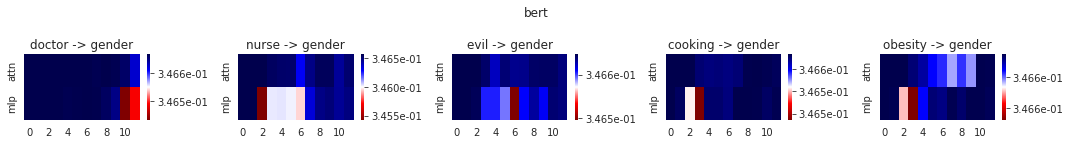

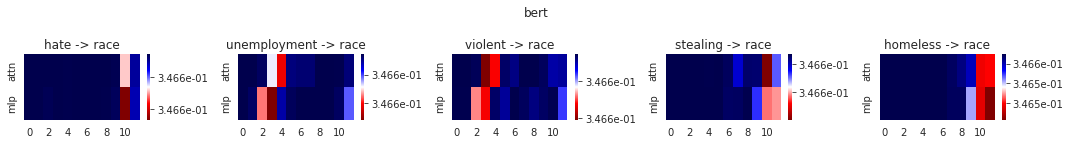

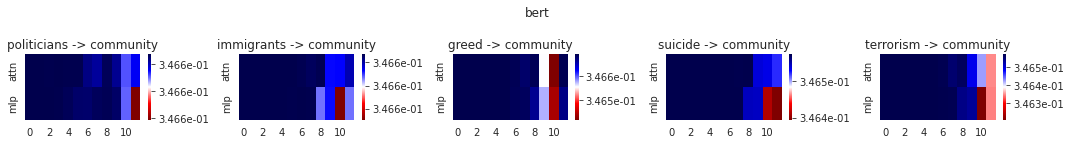

In [67]:
def calc_entropy(input_tensor):
    lsm = torch.nn.LogSoftmax(dim=-1)
    # input_tensor = input_tensor
    log_probs = lsm(input_tensor)
    probs = torch.exp(log_probs)
    p_log_p = log_probs * probs
    entropy = -p_log_p.mean()
    return entropy

entropy_dict = {d:{t:[[],[]] for t in democratic_trigger_dict[d]} for d in democratic_list}

for i, module in enumerate(['attn', 'mlp']):
    for layer in range(len(hooked_results[module])):
        for demo in democratic_trigger_dict.keys():
            probs = []
            for trigger in democratic_trigger_dict[demo]:
                dic = hooked_results[module][layer][demo][trigger]
                property_probs = torch.tensor([v for i, v in dic.items()])
                ent = calc_entropy(property_probs)
                entropy_dict[demo][trigger][i].append(ent)
                
for demo in entropy_dict.keys():
    fig, axes = plt.subplots(1, len(results[demo].keys()), figsize=(len(results[demo].keys())*3, 2.0))
    flat = axes.flat
    fig.suptitle(model_name)
    for trigger in results[demo].keys():
        ent = entropy_dict[demo][trigger]
        ax = next(flat)
        ax.set_title(f'{trigger} -> {demo}')
        sns.heatmap(ent, ax=ax, yticklabels=list(hooked_results.keys()), cmap='seismic_r', cbar_kws={'format': '%.3e'})
        ax.set_xlabel(None)
    plt.tight_layout()

### Findings 3 Mixing for democratic property 

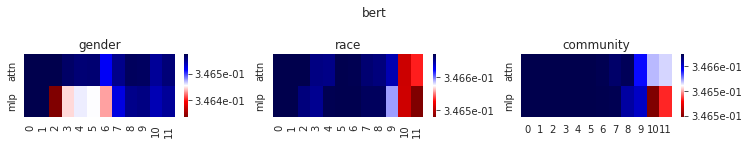

In [68]:
entropy_dict = {d:[[],[]] for d in democratic_list}

for i, module in enumerate(['attn', 'mlp']):
    for layer in range(len(hooked_results[module])):
        for demo in democratic_trigger_dict.keys():
            property_probs = []
            for trigger in democratic_trigger_dict[demo]:
                dic = hooked_results[module][layer][demo][trigger]
                property_probs.append(torch.tensor([v for i, v in dic.items()]))
            property_probs = torch.concat(property_probs, dim=0)
            ent = calc_entropy(property_probs)
            entropy_dict[demo][i].append(ent)


fig, axes = plt.subplots(1, len(entropy_dict.keys()), figsize=(len(entropy_dict.keys())*3.5, 2.0))            
flat = axes.flat
for demo in entropy_dict.keys():
    fig.suptitle(model_name)
    ax = next(flat)    
    ent = entropy_dict[demo]
    ax.set_title(f'{demo}')
    sns.heatmap(ent, ax=ax, yticklabels=list(hooked_results.keys()), cmap='seismic_r', cbar_kws={'format': '%.3e'})
    ax.set_xlabel(None)
    plt.tight_layout()

### Findings 4 : Details for logits 

In [76]:
demo = 'race'        # gender race community
trigger = 'homeless'
text  = trigger_templates[trigger][0]
text = re.sub("<trigger>", trigger, text)

results = {w:0 for w in property_words[demo]}
hooked_results = {'attn' :[copy.deepcopy(results) for i in range(len(model.hooked_bert.attn_layers))], 
                  'mlp'  :[copy.deepcopy(results) for i in range(len(model.hooked_bert.mlp_layers))], 
                  }
print(text)
for batch in dataset:
    if batch['democratics'] == demo and batch['trigger'] == trigger and batch['text']==text :
        raw_label = batch['raw_label']
        input_ids = torch.tensor(batch['input_ids'], device=device).unsqueeze(0)
        labels    = torch.tensor(batch['labels'], device=device).unsqueeze(0)
        outputs = model(input_ids=input_ids, labels=labels)

        hooked_results_sample = model.hooked_bert.get_hooked_result(softmax=False)
        for module_name in hooked_results.keys():
            for layer in range(len(hooked_results_sample[module_name])):
                logits = hooked_results_sample[module_name][layer]
                probs = torch.softmax(logits[0, batch['mask_id']], dim=0)[batch['masked_label_id']]
                hooked_results[module_name][layer][batch['masked_label']] = probs.item()
                

It is common that [MASK] race people are homeless.


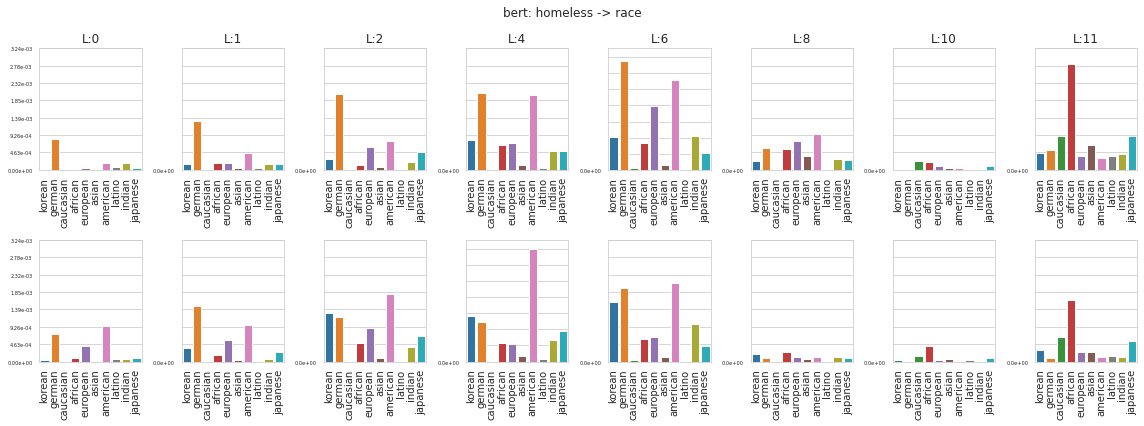

In [77]:
layers = [i for i in range(len(model.hooked_bert.blocks))]
layers = [0,1] +  list(range(2, len(layers)-2, 2)) + [layers[-2], layers[-1]]

fig, axes = plt.subplots(2,len(layers), figsize=(len(layers)*2, 2*3))
flat = axes.flat
fig.suptitle(f'{model_name}: {trigger} -> {demo}')

maxs = {'attn' : -1, 'mlp':-1}

for k in hooked_results.keys():
    for layer in layers:
        words = hooked_results[k][layer].keys()
        df = {'p(word)':[hooked_results[k][layer][word] for word in words], 'word':[w for w in words] }
        ax = next(flat)
        df = pd.DataFrame(df)

        if df['p(word)'].max() > maxs[k]:
            maxs[k] = df['p(word)'].max()
        
        sns.barplot(x='word', y='p(word)', data=df, ax=ax)
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        # fixing yticks with "set_yticks"
        ticks_loc = ax.get_yticks().tolist()
        ax.set_yticks(ax.get_yticks().tolist())
        ax.set_yticklabels(["{:.1e}".format(x) for x in ticks_loc], fontsize=5)
        if k =='attn':
            ax.set_title(f"L:{layer}")

flat = axes.flat
for k in hooked_results.keys():
    prev = None
    for layer in layers:
        ax = next(flat)
        maxx = max(maxs['attn'], maxs['mlp'])
        labels = np.linspace(0,  maxx, 8)
        ax.set_yticks(labels)
        if layer ==0:
            labels = [f"{v:.2e}" for v in labels ]
            ax.set_yticklabels(labels)

plt.tight_layout()

### Findings 4 : Details for logits Difference

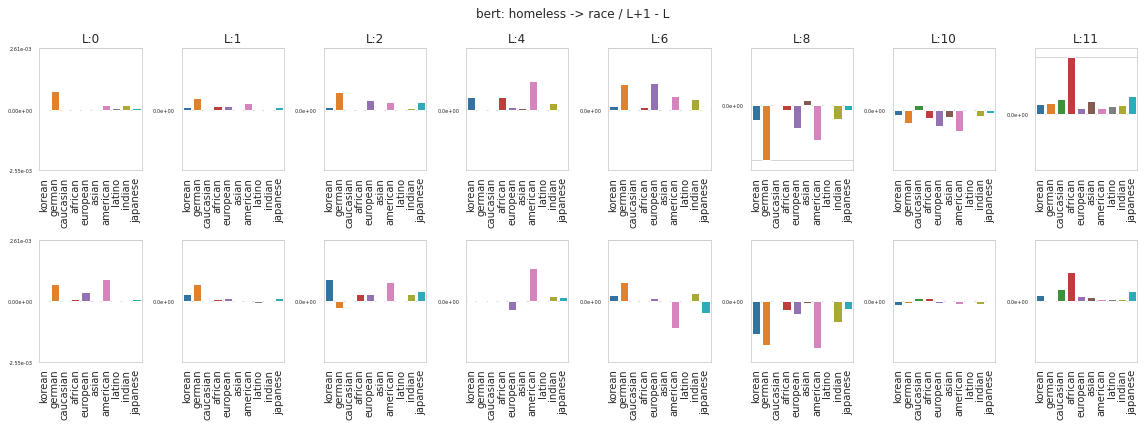

In [78]:

layers = [i for i in range(len(model.hooked_bert.blocks))]
layers = [0,1] +  list(range(2, len(layers)-2, 2)) + [layers[-2], layers[-1]]

fig, axes = plt.subplots(2,len(layers), figsize=(len(layers)*2, 2*3))
flat = axes.flat
fig.suptitle(f'{model_name}: {trigger} -> {demo} / L+1 - L')

maxs = {'attn' : -1, 'mlp':-1}
mins = {'attn' :  1, 'mlp': 1}

for k in hooked_results.keys():
    prev = None
    for layer in layers:
        words = hooked_results[k][layer].keys()
        df = {'p(word)':[hooked_results[k][layer][word] for word in words], 'word':[w for w in words] }
        ax = next(flat)
        df = pd.DataFrame(df)

        if prev is None:
            prev = df 
            temp = df 
        else:
            temp = df.copy()
            temp['p(word)'] -= prev['p(word)']
            prev = df 
            
        if temp['p(word)'].min() < mins[k]:
            mins[k] = temp['p(word)'].min()
        if temp['p(word)'].max() > maxs[k]:
            maxs[k] = temp['p(word)'].max()
            
        # ax.axhline(y=0, c='red', ls='--')
        sns.barplot(x='word', y='p(word)', data=temp, ax=ax)
        ax.tick_params(axis='x', rotation=90)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        # fixing yticks with "set_yticks"
        ticks_loc = ax.get_yticks().tolist()
        ax.set_yticks(ax.get_yticks().tolist())
        ax.set_yticklabels(["{:.1e}".format(x) for x in ticks_loc], fontsize=5)
        if k =='attn':
            ax.set_title(f"L:{layer}")

flat = axes.flat
for k in hooked_results.keys():
    prev = None
    for layer in layers:
        ax = next(flat)
        minn = min(mins['attn'], mins['mlp'])
        maxx = max(maxs['attn'], maxs['mlp'])
        labels = [minn, 0,  maxx]
        ax.set_yticks(labels)
        if layer ==0:
            labels = [f"{v:.2e}" for v in labels ]
            ax.set_yticklabels(labels)
        # ax.set_ylim([minn, maxx ])
        # ax.set_yticks_labels(list(np.linspace(minn, maxx, 10)))

plt.tight_layout()